In [3]:
from PIL import Image
import os
import numpy as np
import PIL.ImageOps
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import itertools
from architecture import Network

/Users/arymehr/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/arymehr/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: /Users/arymehr/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/arymehr/Library/Python/3.9/lib/python/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
num_samples_each_img = 3

In [5]:
imgs = []
for file in os.listdir('data'):
    with Image.open('data/' + file).convert('L') as img:
        img = img.resize((64,64))
        img = PIL.ImageOps.invert(img)
        for i in range(num_samples_each_img):
            imgs.append(np.array([np.array(img)]))

In [6]:
# num_samples = len(imgs)
num_samples = 10
imgs = imgs[:num_samples*num_samples_each_img]
print(f"num images: {num_samples*num_samples_each_img}")

num images: 30


In [7]:
imgs = torch.FloatTensor(imgs)

/var/folders/06/kvt42vp15b106w3b8f5s1k540000gn/T/ipykernel_69464/3805940749.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  imgs = torch.FloatTensor(imgs)


In [8]:
random_perspective = torchvision.transforms.RandomPerspective(0.3, 0.7)
random_rotation = torchvision.transforms.RandomRotation(5)
for i in range(imgs.shape[0]):
    imgs[i] = random_rotation(random_perspective(imgs[i]))

In [9]:
x = torch.clone(imgs)
x = x.apply_(lambda x: 1 if x > 100 else -1)

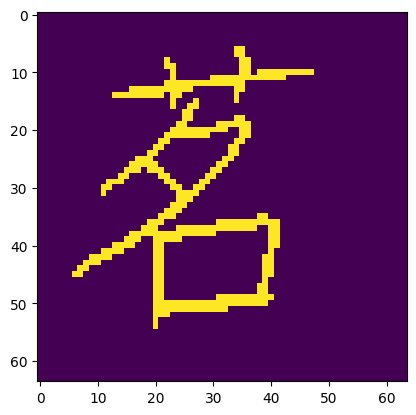

In [10]:
plt.imshow(x[0].swapaxes(2, 0).swapaxes(0, 1))

In [11]:
kanjis = os.listdir('data')[:num_samples]
kanjis = list(map(lambda x: x[:-4], kanjis))
kanji_dict = { i: kanji for (i, kanji) in enumerate(kanjis) }
y = [[i] * num_samples_each_img for i in list(kanji_dict.keys())]
y = list(itertools.chain.from_iterable(y))
y = torch.LongTensor(y)
kanjis

['茗', '謂', '賎', '鬨', '鍼', '弃', '僚', '圖', '怦', '羔']

In [12]:
x.shape, y.shape

(torch.Size([30, 1, 64, 64]), torch.Size([30]))

In [13]:
# x_train = x.view(num_samples, -1)
x_train = x

In [14]:
model = Network(len_kanji_dict=len(kanji_dict))
sum(p.numel() for p in model.parameters())

549382

In [22]:
learning_rate = 0.0005
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
for epoch in range(num_epochs):
  output = model(x_train)
  loss = criterion(output, y)
  train_loss.append(loss.item())
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  predictions = torch.argmax(output, dim=1)
  accuracy = 100 * torch.sum(y == predictions) / len(y)
  print(f'epoch {epoch}/{num_epochs} loss: {loss.item()}  |  accuracy: {torch.round(accuracy, decimals=5)}%                                                   ', end='\r')

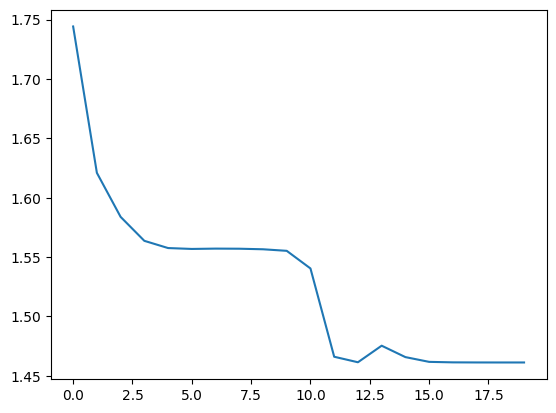

In [23]:
plt.plot(range(len(train_loss)), train_loss)

In [24]:
torch.save(model.state_dict(), 'model.pth')

In [25]:
model = Network(len_kanji_dict=len(kanji_dict))
model.load_state_dict(torch.load('model.pth'))
model.eval()

Network(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.25, inplace=False)
    (12): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2

In [26]:
predictions = model(x_train)
predictions = torch.argmax(predictions, dim=1)
accuracy = 100 * torch.sum(y == predictions) / len(y)
print(f'Accuracy: {torch.round(accuracy, decimals=5)}%')

Accuracy: 100.0%


Correct
茗


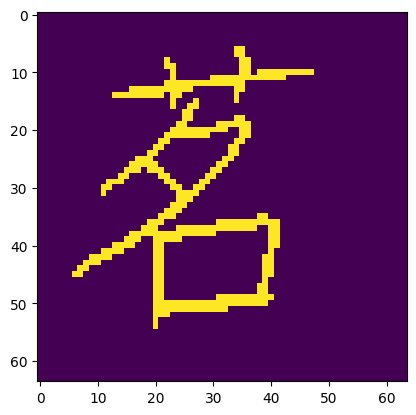

In [27]:
n = 0
plt.imshow(x_train[n].reshape(64,64))
prediction = model(x_train[n].unsqueeze(0))
kanji_prediction = kanji_dict[torch.argmax(prediction).item()]
if y[n] == torch.argmax(prediction):
    print("Correct")
else:
    print("Wrong")
print(kanji_prediction)

In [28]:
def process_screenshot(path):
    with Image.open(path).convert('L') as img:
        img = img.resize((64,64))
        img = PIL.ImageOps.invert(img)
        img = img.point( lambda p: 255 if p > 30 else 0 )
    img = np.expand_dims(np.array(img), 0)
    img = torch.FloatTensor(img)
    return img
    
    
test_img = process_screenshot('../canvas.png')
plt.imshow(test_img[0])
output = model(test_img.unsqueeze(0))
prediction = torch.argmax(output)
prediction = kanji_dict[prediction.item()]
print(f'prediction: {prediction}')
if prediction == kanji_dict[int(n/num_samples_each_img)]:
    print('correct!')
else:
    print('wrong')

FileNotFoundError: [Errno 2] No such file or directory: '../canvas.png'